In [1]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre

In [2]:
# Data path
edge_file = "../data/synthe/edge-table.csv"
node_file = "../data/synthe/node-table.csv"

In [3]:
# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

In [4]:
# Get group membership
group_membership = node_table["group_id"]

In [5]:
# Group detection
# alpha: statistical significance level to find anomalous edges.
# min_edge_weight: the edges with weight less than this value will be removed prior to detecting groups.
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.01, min_edge_weight = 1)

groups = alg.detect(A, threshold=0.15)

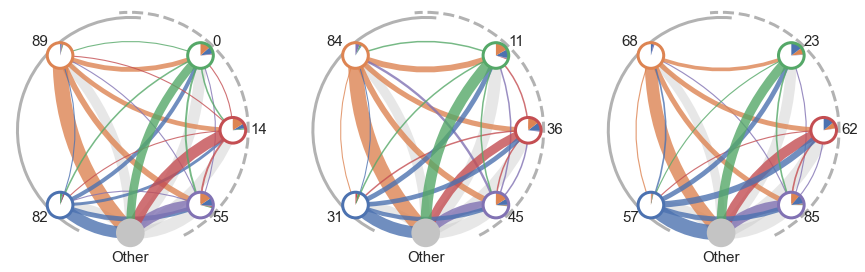

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = len(groups), figsize=(5 * len(groups), 5))

for i, group in enumerate(groups):
    cidre.DrawCartel().draw(group, ax = axes.flat[i])